# Notebook summary
This notebooks is used to normalize skeleton data.

Normalization methods:
- Centralize
- Scale
- Rotate

The pose will be set around (0,0,0) coordinate. Additionally, it will be scaled down to (-1;1) scale for each coordinate. Finally, each sample will be rotated manually to be alligned.

# Load libraries

In [ ]:
%pip install bezier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 72.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.1.3 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.1.3 which is incompatible.
langchain 0.3.9 requires numpy<2,>=1.22.4; python_version < "3.12", but you have numpy 2.1.3 which is incompatible.
matplotlib 3.8.0 requires numpy<2,>=1.21, but you have numpy 2.1.3 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but yo

In [ ]:
from dataclasses import dataclass
from typing import List
import os
import imageio.v2 as imageio

import numpy as np

import json
from google.colab import drive

# Define util functions

In [ ]:
def scale_and_center(data, name_of_data):
    """Scales and centers the input data to the range [-1, 1].

    The function first centers the data by subtracting the mean of each column.
    Then, it scales the data by dividing each column by its range.

    Args:
        data: A NumPy array containing the data to be scaled and centered.
                Shape must be (1, n, n)
        name_of_data: A string representing the name of the data being scaled
                and centered. Used for debugging purposes.

    Returns:
        A NumPy array containing the scaled and centered data.
    """
    assert len(data.shape) == 2,\
    f"Error: Invalid data shape. Expected first dimension to be 1,\
    but got {len(data.shape)}. Name of the data: {name_of_data}"  # Check if first dimension is 1

    mean_vals = data.mean(axis=0)
    centered_array = data - mean_vals

    min_vals = centered_array.min(axis=0)
    max_vals = centered_array.max(axis=0)
    range = max_vals - min_vals

    scaled_array = centered_array/range

    return scaled_array

In [ ]:
def rotation_matrix_y(theta):
  """
  Calculates the rotation matrix for a given angle around the y-axis.

  Args:
    theta: The angle of rotation in degrees.

  Returns:
    A 3x3 NumPy array representing the rotation matrix.
  """
  theta = np.deg2rad(theta)
  cos_theta = np.cos(theta)
  sin_theta = np.sin(theta)
  return np.array([
    [cos_theta, 0, sin_theta],
    [0, 1, 0],
    [-sin_theta, 0, cos_theta]
  ])


def rotation_matrix_z(theta):
  """
  Calculates the rotation matrix for a given angle around the z-axis.

  Args:
    theta: The angle of rotation in degrees.

  Returns:
    A 3x3 NumPy array representing the rotation matrix.
  """
  theta = np.deg2rad(theta)
  cos_theta = np.cos(theta)
  sin_theta = np.sin(theta)
  return np.array([
    [cos_theta, -sin_theta, 0],
    [sin_theta, cos_theta, 0],
    [0, 0, 1]
  ])

In [ ]:
def plot_results(data, joint_edges):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    # Create a figure for the 3D plot only
    fig = plt.figure(figsize=(5, 5.2))  # Adjusted size for a single plot

    # Create a 3D subplot for the pose
    pose_ax = fig.add_subplot(1, 1, 1, projection='3d')
    pose_ax.view_init(5, -75)
    pose_ax.set_xlim3d(-1, 1)
    pose_ax.set_zlim3d(-1, 1)
    pose_ax.set_ylim3d(-1, 1)

    # Adjust the 3D poses for the coordinate system
    #poses3d = pred['poses3d'].numpy()
    #poses3d[..., 1], poses3d[..., 2] = poses3d[..., 2], -poses3d[..., 1]

    # Plot 3D joints and edges
    # data is a list of poses, each pose is a (num_joints, 3) array
    #for pose3d_list in data:  # Iterate through list of poses
        # pose3d_list contains all joints for one person
    for i_start, i_end in joint_edges:
            # pose3d_list[i_start] and pose3d_list[i_end] are the 3D coordinates of the joints
            pose_ax.plot(*zip(data[i_start], data[i_end]), marker='o', markersize=2)
        # Scatter plot for all joints in a single pose
    pose_ax.scatter(*data.T, s=2)

    # Show the figure
    return plt

In [ ]:
def plot_results_2(data1, data2, joint_edges):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    # Create a figure for the two 3D plots side by side
    fig = plt.figure(figsize=(10, 5.2))  # Adjusted size for two plots

    # Create a 3D subplot for the first pose (data1)
    pose_ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    pose_ax1.view_init(0, -90)
    pose_ax1.set_xlim3d(-1, 1)
    pose_ax1.set_zlim3d(-1, 1)
    pose_ax1.set_ylim3d(-1, 1)
    pose_ax1.set_title('Rotated View')

    # Plot 3D joints and edges for data1
    for i_start, i_end in joint_edges:
        pose_ax1.plot(*zip(data1[i_start], data1[i_end]), marker='o', markersize=2)
    pose_ax1.scatter(*data1.T, s=2)

    # Create a 3D subplot for the second pose (data2)
    pose_ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    pose_ax2.view_init(0, -90)
    pose_ax2.set_xlim3d(-1, 1)
    pose_ax2.set_zlim3d(-1, 1)
    pose_ax2.set_ylim3d(-1, 1)
    pose_ax2.set_title('Original View')

    # Plot 3D joints and edges for data2
    for i_start, i_end in joint_edges:
        pose_ax2.plot(*zip(data2[i_start], data2[i_end]), marker='o', markersize=2)
    pose_ax2.scatter(*data2.T, s=2)

    # Show the figure
    plt.show()

In [ ]:
def plot_results_4(data1, data2, joint_edges):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    # Create a figure for the four 3D plots (2x2 grid)
    fig = plt.figure(figsize=(10, 10))  # Adjusted size for four plots

    # Create a list of view angles (elevation and azimuth) for each row
    views = [(0, -90), (5, -75)]  # Example: first row with (5, -75), second with (30, 45)

    # Iterate over the views and create the plots
    for row, (elev, azim) in enumerate(views, start=1):
        # Create the 3D subplot for data1 (left column)
        pose_ax1 = fig.add_subplot(2, 2, 2 * (row - 1) + 1, projection='3d')
        pose_ax1.view_init(elev, azim)
        pose_ax1.set_xlim3d(-1, 1)
        pose_ax1.set_zlim3d(-1, 1)
        pose_ax1.set_ylim3d(-1, 1)
        pose_ax1.set_title(f'Front View {row}')

        # Plot 3D joints and edges for data1
        for i_start, i_end in joint_edges:
            pose_ax1.plot(*zip(data1[i_start], data1[i_end]), marker='o', markersize=2)
        pose_ax1.scatter(*data1.T, s=2)

        # Create the 3D subplot for data2 (right column)
        pose_ax2 = fig.add_subplot(2, 2, 2 * (row - 1) + 2, projection='3d')
        pose_ax2.view_init(elev, azim)
        pose_ax2.set_xlim3d(-1, 1)
        pose_ax2.set_zlim3d(-1, 1)
        pose_ax2.set_ylim3d(-1, 1)
        pose_ax2.set_title(f'Side View {row}')

        # Plot 3D joints and edges for data2
        for i_start, i_end in joint_edges:
            pose_ax2.plot(*zip(data2[i_start], data2[i_end]), marker='o', markersize=2)
        pose_ax2.scatter(*data2.T, s=2)

    # Show the figure with all plots
    plt.tight_layout()
    return plt

# Load data

In [ ]:
# Mount Google drive
drive.mount('/content/drive')

In [ ]:
joint_names_path = "/content/drive/MyDrive/master_thesis/input/test_data/mpi_inf_3dhp_17-annotations/joint_names.json"
joint_edges_path = "/content/drive/MyDrive/master_thesis/input/test_data/mpi_inf_3dhp_17-annotations/joint_edges.json"

joint_name = []
joint_edges = []

In [ ]:
with open(file = joint_names_path, mode='r') as file:
    joint_name = json.load(file)

with open(file = joint_edges_path, mode='r') as file:
   joint_edges = json.load(file)

In [ ]:
annot_data = {}

for sample in list(range(6)):
    file_path = f"/content/drive/MyDrive/master_thesis/input/test_data/mpi_inf_3dhp_17-annotations/sample-{sample}.json"
    with open(file = file_path, mode='r') as file:
        annot_data[f'sample-{sample}'] = json.load(file)

In [ ]:
for sample in list(range(6)):
    for i in range(len(annot_data[f'sample-{sample}'])):
        poses3d = np.array(annot_data[f'sample-{sample}'][f'frame_{i}']['poses3d'])
        # Check if poses3d has enough dimensions to avoid the IndexError
        if poses3d.ndim >= 2 and poses3d.shape[1] >= 3:
            poses3d[..., 1], poses3d[..., 2] = poses3d[..., 2], -poses3d[..., 1]
            annot_data[f'sample-{sample}'][f'frame_{i}']['poses3d'] = poses3d[0]
        else:
            # Handle cases where poses3d is empty or has unexpected shape
            print(f"Warning: Skipping frame {i} in sample-{sample} due to unexpected poses3d shape: {poses3d.shape}")
            annot_data[f'sample-{sample}'][f'frame_{i}']['poses3d'] = poses3d

In [ ]:
annot_data['sample-1']['frame_5']['poses3d']=annot_data['sample-1']['frame_4']['poses3d']

In [ ]:
"""
annot_data['sample-7']['frame_20']['poses3d']=annot_data['sample-7']['frame_19']['poses3d']
annot_data['sample-7']['frame_21']['poses3d']=annot_data['sample-7']['frame_22']['poses3d']

annot_data['sample-12']['frame_0']['poses3d']=annot_data['sample-12']['frame_1']['poses3d']

annot_data['sample-8']['frame_0']['poses3d']=annot_data['sample-8']['frame_9']['poses3d']
annot_data['sample-8']['frame_1']['poses3d']=annot_data['sample-8']['frame_9']['poses3d']
annot_data['sample-8']['frame_2']['poses3d']=annot_data['sample-8']['frame_9']['poses3d']
annot_data['sample-8']['frame_3']['poses3d']=annot_data['sample-8']['frame_9']['poses3d']
annot_data['sample-8']['frame_4']['poses3d']=annot_data['sample-8']['frame_9']['poses3d']
annot_data['sample-8']['frame_5']['poses3d']=annot_data['sample-8']['frame_9']['poses3d']
annot_data['sample-8']['frame_6']['poses3d']=annot_data['sample-8']['frame_9']['poses3d']
annot_data['sample-8']['frame_7']['poses3d']=annot_data['sample-8']['frame_9']['poses3d']
annot_data['sample-8']['frame_8']['poses3d']=annot_data['sample-8']['frame_9']['poses3d']
"""

In [ ]:
annot_data['sample-7']['frame_21']['poses3d']

array([[   59.66283035,  7000.66113281,  -298.93499756],
       [   48.34243774,  7063.85058594,  -537.98046875],
       [ -111.60160828,  7100.17822266,  -579.5177002 ],
       [ -340.67028809,  7076.25683594,  -822.10754395],
       [ -463.89581299,  6987.79785156, -1012.90655518],
       [  203.6946106 ,  7092.6015625 ,  -586.55645752],
       [  430.34658813,  7049.15917969,  -832.82580566],
       [  559.27453613,  6946.54199219, -1010.45935059],
       [  -80.89174652,  7415.48583984,  -818.43493652],
       [ -211.23532104,  7083.30371094,  -932.9251709 ],
       [ -151.55975342,  7248.98144531, -1295.0501709 ],
       [  178.48730469,  7408.17675781,  -818.19659424],
       [  283.16656494,  7064.18603516,  -916.99334717],
       [  279.34603882,  7226.66259766, -1283.89038086],
       [   48.84725189,  7415.41259766,  -817.6953125 ],
       [   46.66432953,  7308.09619141,  -645.83178711],
       [   50.22330093,  6995.67480469,  -476.54949951]])

# Scale and center the data

In [ ]:
for sample in list(range(6)):
    for i in range(len(annot_data[f'sample-{sample}'])):
        data = annot_data[f'sample-{sample}'][f'frame_{i}']['poses3d']
        try:
            scaled_data = scale_and_center(data = data, name_of_data=f'sample-{sample}_frame_{i}')
        except AssertionError as e:
            print(f"Assertion failed for item: sample-{sample}_frame_{i}, error: {e}")
            continue

        annot_data[f'sample-{sample}'][f'frame_{i}']['poses3d'] = scaled_data

# Rotate the samples

## 1 Data rotation checklist
In this section we go sample by sample and exclude those samples which have poor estimated coordinates. This is done by rotating the samples and looking if it looks decent or not

In [ ]:
for i in range(len(annot_data[f'sample-0'])):
        data = annot_data[f'sample-0'][f'frame_{i}']['poses3d']
        rotated_data = data @ rotation_matrix_z(5).T
        annot_data[f'sample-0'][f'frame_{i}']['poses3d'] = rotated_data

for i in range(len(annot_data[f'sample-1'])):
        data = annot_data[f'sample-1'][f'frame_{i}']['poses3d']
        rotated_data = data @ rotation_matrix_z(5).T
        annot_data[f'sample-1'][f'frame_{i}']['poses3d'] = rotated_data

for i in range(len(annot_data[f'sample-2'])):
        data = annot_data[f'sample-2'][f'frame_{i}']['poses3d']
        rotated_data = data @ rotation_matrix_z(5).T
        annot_data[f'sample-2'][f'frame_{i}']['poses3d'] = rotated_data

for i in range(len(annot_data[f'sample-3'])):
        data = annot_data[f'sample-3'][f'frame_{i}']['poses3d']
        rotated_data = data @ rotation_matrix_z(5).T
        annot_data[f'sample-3'][f'frame_{i}']['poses3d'] = rotated_data

for i in range(len(annot_data[f'sample-4'])):
        data = annot_data[f'sample-4'][f'frame_{i}']['poses3d']
        rotated_data = data @ rotation_matrix_z(5).T
        annot_data[f'sample-4'][f'frame_{i}']['poses3d'] = rotated_data

for i in range(len(annot_data[f'sample-5'])):
        data = annot_data[f'sample-5'][f'frame_{i}']['poses3d']
        rotated_data = data @ rotation_matrix_z(5).T
        annot_data[f'sample-5'][f'frame_{i}']['poses3d'] = rotated_data

# Save the rotated data

In [ ]:
LIST_OF_GOOD_SAMPLES = [0,1,2,3,4,5]

# Dictionary to numpy array

In [ ]:
sorted_dictionary = {}
for sample in list(range(6)):
    sorted_frames = [annot_data[f'sample-{sample}'][key]['poses3d'] for key in sorted(annot_data[f'sample-{sample}'].keys(), key=lambda x: int(x.split('_')[1]))]
    # Check for shape consistency before stacking
    shapes = [frame.shape for frame in sorted_frames]
    if len(set(shapes)) > 1:  # If more than one unique shape is found
        print(f"Inconsistent shapes found for sample-{sample}: {shapes}")
        # Handle the inconsistency (e.g., skip, pad, resize, etc.)
        # Example: Skip the sample with inconsistent shapes
        continue
    sorted_dictionary[f'sample-{sample}'] = np.stack(sorted_frames)

# Gif generation

In [ ]:
directory_path = "/content/drive/MyDrive/master_thesis/output/test_data/mpi_inf_3dhp_17_skeleton_gifs/"
temp_directory_path = "/content/temp/"

if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory created: {directory_path}")

if not os.path.exists(temp_directory_path):
    os.makedirs(temp_directory_path)
    print(f"Directory created: {temp_directory_path}")

for sample in list(range(6)):
    images = []
    for frame in list(range(sorted_dictionary[f'sample-{sample}'].shape[0])):
        file_path = f'/content/temp/frame-{frame}.png'
        rotated_data = sorted_dictionary[f'sample-{sample}'][frame] @ rotation_matrix_z(90).T

        frame_plot = plot_results_4(data1 = sorted_dictionary[f'sample-{sample}'][frame], data2 = rotated_data, joint_edges = joint_edges)
        frame_plot.savefig(file_path)
        images.append(imageio.imread(file_path))
        frame_plot.close()
        print(f'Done: sample- {sample}, frame- {frame}')

    imageio.mimsave(f'/content/drive/MyDrive/master_thesis/output/test_data/mpi_inf_3dhp_17_skeleton_gifs/sample-{sample}.gif', images, fps=24, loop=0)
    print(f'GIF generated for sample: {sample}')

Done: sample- 0, frame- 0
Done: sample- 0, frame- 1
Done: sample- 0, frame- 2
Done: sample- 0, frame- 3
Done: sample- 0, frame- 4
Done: sample- 0, frame- 5
Done: sample- 0, frame- 6
Done: sample- 0, frame- 7
Done: sample- 0, frame- 8
Done: sample- 0, frame- 9
Done: sample- 0, frame- 10
Done: sample- 0, frame- 11
Done: sample- 0, frame- 12
Done: sample- 0, frame- 13
Done: sample- 0, frame- 14
Done: sample- 0, frame- 15
Done: sample- 0, frame- 16
Done: sample- 0, frame- 17
Done: sample- 0, frame- 18
Done: sample- 0, frame- 19
Done: sample- 0, frame- 20
Done: sample- 0, frame- 21
Done: sample- 0, frame- 22
Done: sample- 0, frame- 23
Done: sample- 0, frame- 24
Done: sample- 0, frame- 25
Done: sample- 0, frame- 26
Done: sample- 0, frame- 27
Done: sample- 0, frame- 28
Done: sample- 0, frame- 29
Done: sample- 0, frame- 30
Done: sample- 0, frame- 31
Done: sample- 0, frame- 32
Done: sample- 0, frame- 33
Done: sample- 0, frame- 34
Done: sample- 0, frame- 35
Done: sample- 0, frame- 36
Done: sampl

KeyError: 'sample-6'

# Data smoothing


In [ ]:
import bezier
import numpy as np

## Smooth spine line

In [ ]:
joint_edges

[[0, 16],
 [1, 16],
 [2, 3],
 [3, 4],
 [5, 6],
 [6, 7],
 [8, 9],
 [8, 14],
 [9, 10],
 [11, 12],
 [11, 14],
 [12, 13],
 [15, 14],
 [1, 2],
 [1, 5],
 [1, 15],
 [1, 5],
 [1, 2]]

In [ ]:
joint_name

['htop',
 'neck',
 'rsho',
 'relb',
 'rwri',
 'lsho',
 'lelb',
 'lwri',
 'rhip',
 'rkne',
 'rank',
 'lhip',
 'lkne',
 'lank',
 'pelv',
 'spin',
 'head']

In [ ]:
def smooth_spine_with_bezier(data):
  """Smooths the spine joints using a Bézier curve.

  Args:
    data: A NumPy array with shape (30, 3) representing the skeleton data.

  Returns:
    A NumPy array with the same shape as data, containing the smoothed spine.
  """

  # Define the indices of the spine joints
  spine_indices = [14, 15, 1]  # Pelvis, Spine, Neck

  # Extract the coordinates of the spine joints
  spine_coords = data[spine_indices]

  # Create a Bézier curve using the spine coordinates as nodes
  nodes = spine_coords.T  # Transpose to match bezier library format
  curve = bezier.Curve.from_nodes(nodes)

  # Evaluate the curve at evenly spaced points to get smoothed coordinates
  # You can adjust the number of evaluation points for finer smoothing
  evaluation_times = np.linspace(0, 1, len(spine_indices))
  smoothed_spine_coords = curve.evaluate_multi(evaluation_times).T

  # Update the original data with the smoothed spine coordinates
  data[spine_indices] = smoothed_spine_coords

  return data

In [ ]:
spine_adjusted_sample = smooth_spine_with_bezier(data = sorted_dictionary['sample-0'][60])

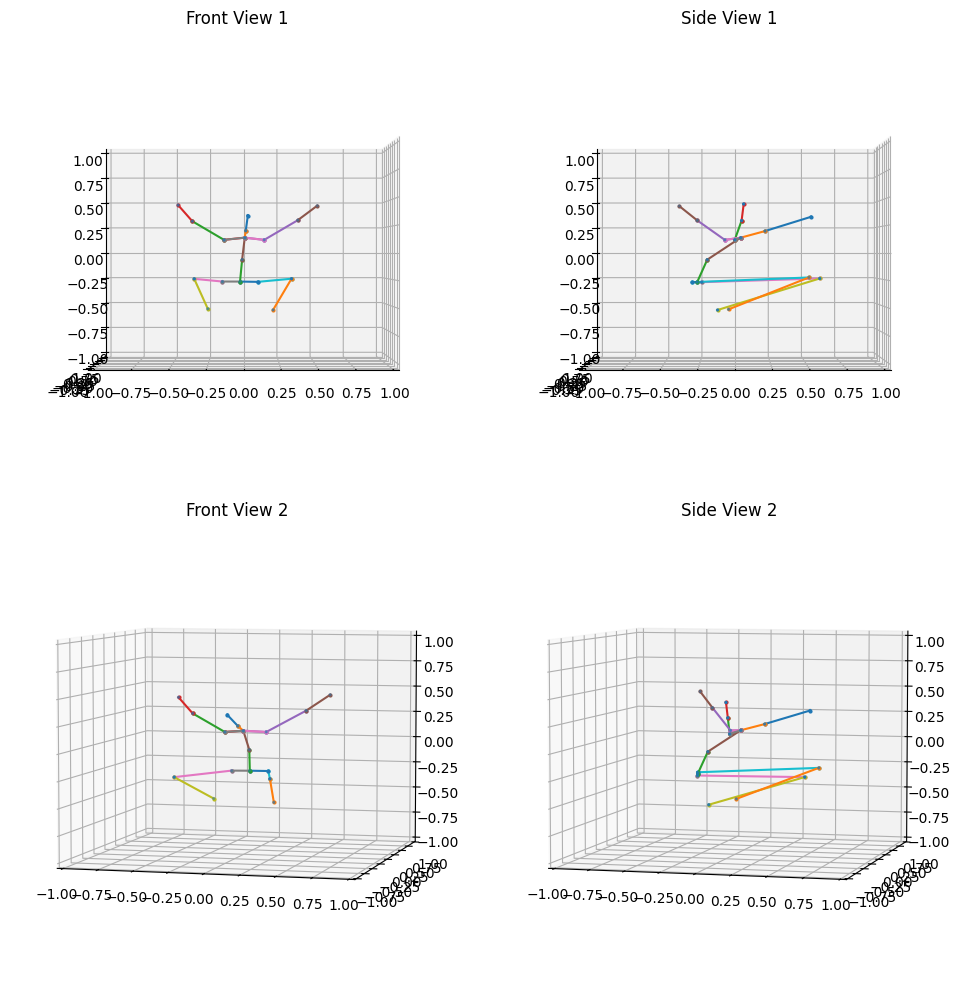

In [ ]:
rotated_data = spine_adjusted_sample @ rotation_matrix_z(90).T
frame_plot = plot_results_4(data1 = spine_adjusted_sample, data2 = rotated_data, joint_edges = joint_edges)
frame_plot.show()

In [ ]:
for sample in list(range(6)):
    for frame in range(len(sorted_dictionary[f'sample-{sample}'][0])):
        spine_adjusted_sample = smooth_spine_with_bezier(data = sorted_dictionary[f'sample-{sample}'][frame])
        sorted_dictionary[f'sample-{sample}'][frame] = spine_adjusted_sample

## Smooth in time series


In [ ]:
def smooth_skeleton_data(sample_data):
  """Smooths skeleton data using Bézier curves.

  Args:
    sample_data: A NumPy array with shape (n, 30, 3) representing a single sample.

  Returns:
    A NumPy array with the same shape as sample_data, containing the smoothed data.
  """
  num_frames = sample_data.shape[0]
  num_points = sample_data.shape[1]

  smoothed_data = np.zeros_like(sample_data)

  for point_index in range(num_points):
    # Get the coordinates of the point across all frames
    point_coords = sample_data[:, point_index, :]

    # Create a Bézier curve using the point coordinates as nodes
    nodes = point_coords.T # Transpose to match bezier library format
    curve = bezier.Curve.from_nodes(nodes)

    # Evaluate the curve at evenly spaced points to get smoothed coordinates
    # You can adjust the number of evaluation points for finer smoothing
    evaluation_times = np.linspace(0, 1, num_frames)
    smoothed_coords = curve.evaluate_multi(evaluation_times).T

    # Update the smoothed_data array with the smoothed coordinates
    smoothed_data[:, point_index, :] = smoothed_coords

  return smoothed_data

In [ ]:
samples = list(sorted_dictionary.values())
smoothed_samples = []

for sample_data in samples:
    smoothed_sample = smooth_skeleton_data(sample_data)
    smoothed_samples.append(smoothed_sample)

# Smoothed gif

In [ ]:
directory_path = "/content/drive/MyDrive/master_thesis/output/test_data/mpi_inf_3dhp_17_smoothed_skeleton_gifs/"
temp_directory_path = "/content/smoothed_temp/"

if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory created: {directory_path}")

if not os.path.exists(temp_directory_path):
    os.makedirs(temp_directory_path)
    print(f"Directory created: {temp_directory_path}")

for sample in list(range(20)):
    images = []
    for frame in list(range(smoothed_samples[sample].shape[0])):
        file_path = f'/content/smoothed_temp/frame-{frame}.png'
        rotated_data = smoothed_samples[sample][frame] @ rotation_matrix_z(90).T

        frame_plot = plot_results_4(data1 = smoothed_samples[sample][frame], data2 = rotated_data, joint_edges = joint_edges)
        frame_plot.savefig(file_path)
        images.append(imageio.imread(file_path))
        frame_plot.close()
        print(f'Done: sample- {sample}, frame- {frame}')

    imageio.mimsave(f'/content/drive/MyDrive/master_thesis/output/test_data/mpi_inf_3dhp_17_smoothed_skeleton_gifs/sample-{sample}.gif', images, fps=24, loop=0)
    print(f'GIF generated for sample: {sample}')

Directory created: /content/drive/MyDrive/master_thesis/output/test_data/mpi_inf_3dhp_17_smoothed_skeleton_gifs/
Directory created: /content/smoothed_temp/
Done: sample- 0, frame- 0
Done: sample- 0, frame- 1
Done: sample- 0, frame- 2
Done: sample- 0, frame- 3
Done: sample- 0, frame- 4
Done: sample- 0, frame- 5
Done: sample- 0, frame- 6
Done: sample- 0, frame- 7
Done: sample- 0, frame- 8
Done: sample- 0, frame- 9
Done: sample- 0, frame- 10
Done: sample- 0, frame- 11
Done: sample- 0, frame- 12
Done: sample- 0, frame- 13
Done: sample- 0, frame- 14
Done: sample- 0, frame- 15
Done: sample- 0, frame- 16
Done: sample- 0, frame- 17
Done: sample- 0, frame- 18
Done: sample- 0, frame- 19
Done: sample- 0, frame- 20
Done: sample- 0, frame- 21
Done: sample- 0, frame- 22
Done: sample- 0, frame- 23
Done: sample- 0, frame- 24
Done: sample- 0, frame- 25
Done: sample- 0, frame- 26
Done: sample- 0, frame- 27
Done: sample- 0, frame- 28
Done: sample- 0, frame- 29
Done: sample- 0, frame- 30
Done: sample- 0, 

IndexError: list index out of range

In [ ]:
directory_path = "/content/drive/MyDrive/master_thesis/input/smoothed_annotations/test_data/mpi_inf_3dhp_17"

if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory created: {directory_path}")


for sample in LIST_OF_GOOD_SAMPLES:
    file_path = f"/content/drive/MyDrive/master_thesis/input/smoothed_annotations/test_data/mpi_inf_3dhp_17/sample_{sample}.json"

    # Create a deep copy of the data to avoid modifying the original annot_data
    data_to_save = smoothed_samples[sample].copy()
    data_to_save = data_to_save.tolist()

    # Iterate through frames and convert 'poses3d' to list
    #for frame_key in data_to_save:
    #    if 'poses3d' in data_to_save[frame_key]:
            # Convert NumPy array to list using .tolist()
    #        data_to_save[frame_key]['poses3d'] = data_to_save[frame_key]['poses3d'].tolist()

    with open(file_path, "w") as file:
        json.dump(data_to_save, file)

Directory created: /content/drive/MyDrive/master_thesis/input/smoothed_annotations/test_data/mpi_inf_3dhp_17


# Golden trajectory

In [ ]:
def calculate_average_trajectory_variable_frames(smoothed_samples):
  """Calculates the average joint trajectory with variable frame lengths.

  Args:
    smoothed_samples: A list of NumPy arrays, each with shape (n_i, 30, 3)
                      representing a smoothed sample, where n_i can vary.

  Returns:
    A NumPy array representing the average trajectory.
    Shape will be (max_frames, 30, 3), where max_frames is the maximum
    number of frames across all samples. Shorter samples will be padded
    with NaNs.
  """

  # Find the maximum number of frames across all samples
  max_frames = max(sample.shape[0] for sample in smoothed_samples)

  # Create an array to store the padded samples
  padded_samples = np.empty((len(smoothed_samples), max_frames, 17, 3))
  padded_samples[:] = np.nan  # Initialize with NaNs

  # Pad each sample with NaNs to the maximum frame length
  for i, sample in enumerate(smoothed_samples):
    padded_samples[i, :sample.shape[0]] = sample

  # Calculate the average along the sample axis, ignoring NaNs
  average_trajectory = np.nanmean(padded_samples, axis=0)

  return average_trajectory

In [ ]:
LIST_OF_GOOD_SAMPLES

[0, 1, 2, 3, 4, 5]

In [ ]:
good_smoothed_samples = [smoothed_samples[sample] for sample in LIST_OF_GOOD_SAMPLES]

In [ ]:
golden_trajectory = calculate_average_trajectory_variable_frames(good_smoothed_samples)

In [ ]:
golden_trajectory.shape[0]

163

In [ ]:
golden_trajectory[0]

array([[ 9.88831491e-04, -3.91202070e-01,  5.50351150e-01],
       [-1.10276222e-03, -2.30920052e-01,  2.85998851e-01],
       [-1.64637407e-01, -1.65278602e-01,  2.31475109e-01],
       [-4.08939146e-01, -5.92703976e-02, -1.94053849e-02],
       [-5.42195807e-01, -1.10106636e-01, -2.41062012e-01],
       [ 1.63426396e-01, -1.50272924e-01,  2.32614175e-01],
       [ 3.93369034e-01, -6.75259829e-03, -2.71238999e-02],
       [ 5.07813395e-01, -1.30402019e-02, -2.56863428e-01],
       [-1.32049750e-01,  4.95083971e-01, -6.23526046e-02],
       [-2.57469887e-01, -3.57228187e-01, -9.48061056e-02],
       [-1.93318178e-01,  1.97908557e-01, -4.42274360e-01],
       [ 1.33391765e-01,  5.10592650e-01, -5.97559714e-02],
       [ 2.88854817e-01, -3.25232333e-01, -9.53055186e-02],
       [ 2.14408817e-01,  1.85909669e-01, -4.48354290e-01],
       [ 5.37203668e-04,  5.05972926e-01, -6.05571794e-02],
       [-9.36062680e-04,  1.79823629e-01,  1.22935450e-01],
       [-1.81408485e-04, -3.92878977e-01

In [ ]:
directory_path = "/content/drive/MyDrive/master_thesis/output/test_data/mpi_inf_3dhp_17_golden_trajectory/"
temp_directory_path = "/content/temp/"

if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory created: {directory_path}")

if not os.path.exists(temp_directory_path):
    os.makedirs(temp_directory_path)
    print(f"Directory created: {temp_directory_path}")

images = []
for frame in list(range(golden_trajectory.shape[0])):
        file_path = f'/content/temp/frame-{frame}.png'
        rotated_data = golden_trajectory[frame] @ rotation_matrix_z(90).T

        frame_plot = plot_results_4(data1 =golden_trajectory[frame], data2 = rotated_data, joint_edges = joint_edges)
        frame_plot.savefig(file_path)
        images.append(imageio.imread(file_path))
        frame_plot.close()
        print(f'Done: frame- {frame}')

imageio.mimsave('/content/drive/MyDrive/master_thesis/output/test_data/mpi_inf_3dhp_17_golden_trajectory/mpi_inf_3dhp_17_golden_trajectory.gif', images, fps=24, loop=0)

Directory created: /content/drive/MyDrive/master_thesis/output/test_data/mpi_inf_3dhp_17_golden_trajectory/
Done: frame- 0
Done: frame- 1
Done: frame- 2
Done: frame- 3
Done: frame- 4
Done: frame- 5
Done: frame- 6
Done: frame- 7
Done: frame- 8
Done: frame- 9
Done: frame- 10
Done: frame- 11
Done: frame- 12
Done: frame- 13
Done: frame- 14
Done: frame- 15
Done: frame- 16
Done: frame- 17
Done: frame- 18
Done: frame- 19
Done: frame- 20
Done: frame- 21
Done: frame- 22
Done: frame- 23
Done: frame- 24
Done: frame- 25
Done: frame- 26
Done: frame- 27
Done: frame- 28
Done: frame- 29
Done: frame- 30
Done: frame- 31
Done: frame- 32
Done: frame- 33
Done: frame- 34
Done: frame- 35
Done: frame- 36
Done: frame- 37
Done: frame- 38
Done: frame- 39
Done: frame- 40
Done: frame- 41
Done: frame- 42
Done: frame- 43
Done: frame- 44
Done: frame- 45
Done: frame- 46
Done: frame- 47
Done: frame- 48
Done: frame- 49
Done: frame- 50
Done: frame- 51
Done: frame- 52
Done: frame- 53
Done: frame- 54
Done: frame- 55
Done: 

In [ ]:
directory_path = "/content/drive/MyDrive/master_thesis/input/smoothed_annotations/test_data/mpi_inf_3dhp_17"

if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory created: {directory_path}")

file_path = f"/content/drive/MyDrive/master_thesis/input/smoothed_annotations/test_data/mpi_inf_3dhp_17/golden_trajectory.json"

golden_trajectory_list = golden_trajectory.tolist()

with open(file_path, "w") as file:
        json.dump(golden_trajectory_list, file)

